# 🏢 AI-Driven Company Intelligence Analysis
**SDS Datathon 2026 - Champions Group Dataset**

---

## 📋 Problem Statement
Develop a prototype system that derives actionable insights from company-level data by analyzing firmographic, operational, and organizational attributes.

### Objectives
1.  **Data Cleaning**: Robust handling of missing values and inconsistencies.
2.  **Segmentation**: Multi-dimensional clustering of companies.
3.  **Benchmarking**: Comparing performance against industry peers.
4.  **Lead Scoring**: Identifying high-value B2B targets.
5.  **Risk Detection**: Flagging anomalies and potential risks.

## 1. Environment Setup & Data Loading

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Libraries loaded.")

✅ Libraries loaded.


## 2. Data Loading & Initial Exploration

In [122]:
# Load Dataset
try:
    df = pd.read_csv('champions_group_data.csv')
    print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print("❌ Error: 'champions_group_data.csv' not found. Please ensure the file is in the correct directory.")

📊 Dataset Shape: 8,559 rows × 72 columns


## 3. Data Quality Assessment

In [123]:
def data_quality_report(df):
    """
    Generate comprehensive data quality report
    """
    report = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Null Count': df.isnull().sum().values,
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2).values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Value': df.iloc[0].values
    })
    return report.sort_values('Null Percentage', ascending=False)

quality_report = data_quality_report(df)
print("📊 Data Quality Report (Top 20 columns by missing values):")
quality_report.head(20)

📊 Data Quality Report (Top 20 columns by missing values):


,Column,Non-Null Count,Null Count,Null Percentage,Dtype,Unique Values,Sample Value
24,Ticker,4,8555,99.950,float64,4,NaN
49,Registration Number Type,8,8551,99.910,object,1,NaN
58,Manufacturing Status,261,8298,96.950,object,1,NaN
2,Website,625,7934,92.700,object,498,NaN
60,ANZSIC Code,1426,7133,83.340,float64,136,3322.000
61,ANZSIC Description,1428,7131,83.320,object,137,Metal and Mineral Wholesaling
54,Is Headquarters,1467,7092,82.860,float64,2,0.000
23,NACE Rev 2 Description,1512,7047,82.330,object,177,Wholesale of metals and metal ores
63,ISIC Rev 4 Description,1514,7045,82.310,object,147,Wholesale of metals and metal ores
55,Is Domestic Ultimate,1514,7045,82.310,float64,2,0.000


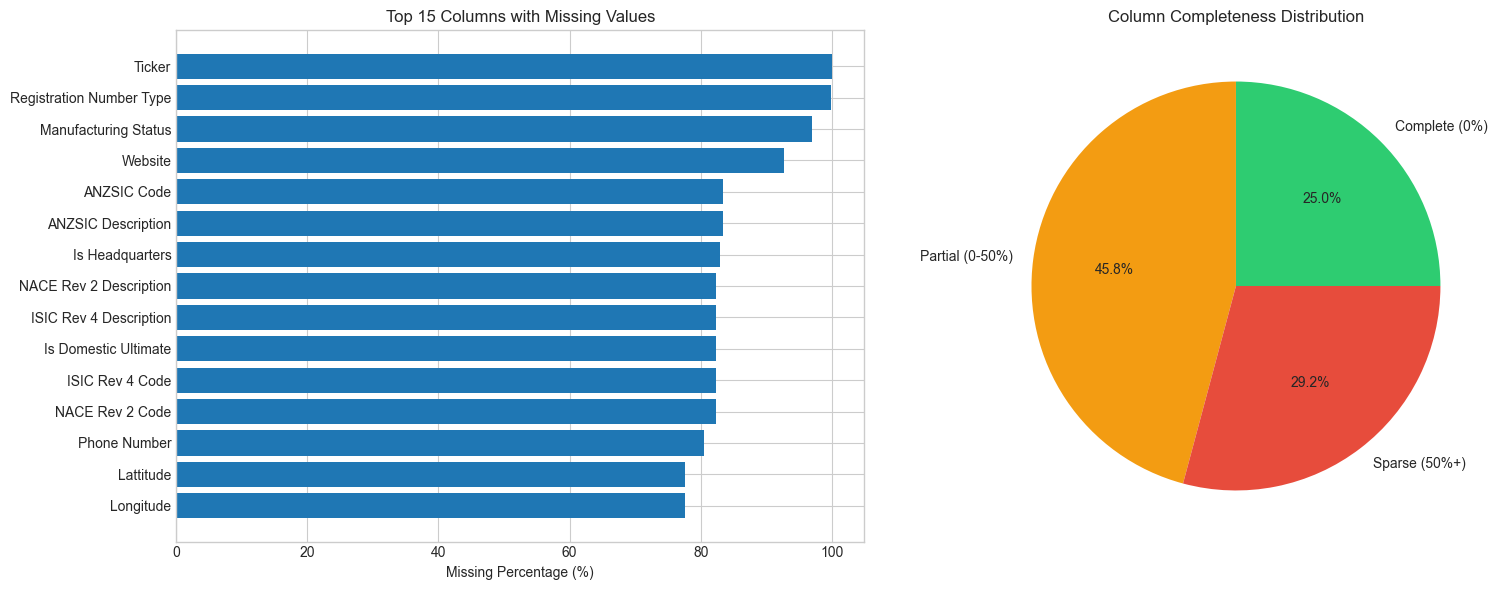

In [124]:
# Visualize missing data pattern
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Missing percentage bar chart (top 15)
top_missing = quality_report.head(15)
axes[0].barh(top_missing['Column'].astype(str), top_missing['Null Percentage'])
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Top 15 Columns with Missing Values')
axes[0].invert_yaxis()

# Data completeness pie chart
complete_cols = (quality_report['Null Percentage'] == 0).sum()
partial_cols = ((quality_report['Null Percentage'] > 0) & (quality_report['Null Percentage'] < 50)).sum()
sparse_cols = (quality_report['Null Percentage'] >= 50).sum()

axes[1].pie([complete_cols, partial_cols, sparse_cols], 
            labels=['Complete (0%)', 'Partial (0-50%)', 'Sparse (50%+)'],
            autopct='%1.1f%%', colors=['#2ecc71', '#f39c12', '#e74c3c'])
axes[1].set_title('Column Completeness Distribution')

plt.tight_layout()
plt.show()

## 4. Exploratory Data Analysis (EDA)

### 4.1 Geographic Distribution

In [125]:
# Country distribution
df['Country'] = df['Country'].str.strip().str.upper()
country_dist = df['Country'].value_counts().head(20)

fig = px.bar(x=country_dist.values, y=country_dist.index, orientation='h',
             title='Top 20 Countries by Company Count',
             labels={'x': 'Number of Companies', 'y': 'Country'})
fig.update_layout(height=600)
fig.show()

In [126]:
# Region distribution
if 'Region' in df.columns:
    df['Region'] = df['Region'].str.strip()
    region_dist = df['Region'].value_counts()
    
    fig = px.pie(values=region_dist.values, names=region_dist.index,
                 title='Company Distribution by Region')
    fig.show()

### 4.2 Company Size & Revenue Analysis

In [127]:
# Convert numeric columns
def clean_numeric(col):
    """Clean and convert to numeric"""
    if df[col].dtype == 'object':
        # Remove common non-numeric characters
        cleaned = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        return pd.to_numeric(cleaned, errors='coerce')
    return pd.to_numeric(df[col], errors='coerce')

# Key numeric columns
df['Employees_Total_Clean'] = clean_numeric('Employees Total')
df['Revenue_USD_Clean'] = clean_numeric('Revenue (USD)')
df['Employees_Single_Site_Clean'] = clean_numeric('Employees Single Site')

print("📊 Employee & Revenue Statistics:")
print(df[['Employees_Total_Clean', 'Revenue_USD_Clean', 'Employees_Single_Site_Clean']].describe())

📊 Employee & Revenue Statistics:
       Employees_Total_Clean  Revenue_USD_Clean  Employees_Single_Site_Clean
count               8559.000           8559.000                     8557.000
mean                  22.658        3960698.980                       22.666
std                   99.689       45102121.815                       99.700
min                    0.000              0.000                        0.000
25%                    0.000              0.000                        0.000
50%                    4.000         443445.000                        4.000
75%                   21.000        2099812.000                       21.000
max                 3290.000     2961727200.000                     3290.000


In [128]:
# Revenue distribution (log scale)
revenue_data = df['Revenue_USD_Clean'].dropna()
revenue_data = revenue_data[revenue_data > 0]

fig = px.histogram(x=np.log10(revenue_data), nbins=50,
                   title='Revenue Distribution (Log10 Scale)',
                   labels={'x': 'Log10(Revenue USD)'})
fig.show()

In [129]:
# Create company size segments
def company_size_segment(employees):
    if pd.isna(employees) or employees == 0:
        return 'Unknown'
    elif employees < 10:
        return 'Micro (1-9)'
    elif employees < 50:
        return 'Small (10-49)'
    elif employees < 250:
        return 'Medium (50-249)'
    elif employees < 1000:
        return 'Large (250-999)'
    else:
        return 'Enterprise (1000+)'

df['Company_Size_Segment'] = df['Employees_Total_Clean'].apply(company_size_segment)

# Visualize
size_order = ['Micro (1-9)', 'Small (10-49)', 'Medium (50-249)', 'Large (250-999)', 'Enterprise (1000+)', 'Unknown']
size_dist = df['Company_Size_Segment'].value_counts().reindex(size_order, fill_value=0)

fig = px.bar(x=size_dist.index, y=size_dist.values,
             title='Company Size Distribution',
             labels={'x': 'Size Segment', 'y': 'Number of Companies'},
             color=size_dist.index)
fig.show()

### 4.3 Industry Analysis

In [130]:
# SIC Code Analysis
df['SIC Description'] = df['SIC Description'].str.strip()
industry_dist = df['SIC Description'].value_counts().head(20)

fig = px.bar(x=industry_dist.values, y=industry_dist.index, orientation='h',
             title='Top 20 Industries (SIC Description)',
             labels={'x': 'Number of Companies', 'y': 'Industry'})
fig.update_layout(height=700)
fig.show()

In [131]:
# NAICS Industry Analysis
if 'NAICS Description' in df.columns:
    df['NAICS Description'] = df['NAICS Description'].str.strip()
    naics_dist = df['NAICS Description'].value_counts().head(15)
    
    fig = px.treemap(names=naics_dist.index, parents=[''] * len(naics_dist), values=naics_dist.values,
                     title='Industry Distribution (NAICS) - Treemap')
    fig.show()

### 4.4 Entity & Ownership Analysis

In [132]:
# Entity Type Distribution
if 'Entity Type' in df.columns:
    df['Entity Type'] = df['Entity Type'].str.strip()
    entity_dist = df['Entity Type'].value_counts()
    
    fig = px.pie(values=entity_dist.values, names=entity_dist.index,
                 title='Entity Type Distribution (HQ, Subsidiary, Branch, Single Location)',
                 hole=0.4)
    fig.show()

In [133]:
# Ownership Type
if 'Ownership Type' in df.columns:
    df['Ownership Type'] = df['Ownership Type'].str.strip()
    ownership_dist = df['Ownership Type'].value_counts()
    
    fig = px.pie(values=ownership_dist.values, names=ownership_dist.index,
                 title='Ownership Type Distribution (Private vs Public)')
    fig.show()

### 4.5 IT Infrastructure Analysis

In [134]:
# IT related columns analysis
it_columns = ['IT Budget', 'IT Spend', 'No. of PC', 'No. of Desktops', 'No. of Laptops', 
              'No. of Routers', 'No. of Servers', 'No. of Storage Devices']

it_exists = [col for col in it_columns if col in df.columns]
print(f"IT-related columns in dataset: {it_exists}")

# Check IT data completeness
for col in it_exists:
    non_null = df[col].notnull().sum()
    pct = (non_null / len(df) * 100)
    print(f"{col}: {non_null:,} non-null values ({pct:.1f}%)")

IT-related columns in dataset: ['IT Budget', 'No. of PC', 'No. of Desktops', 'No. of Laptops', 'No. of Routers', 'No. of Servers', 'No. of Storage Devices']
IT Budget: 8,559 non-null values (100.0%)
No. of PC: 8,278 non-null values (96.7%)
No. of Desktops: 8,218 non-null values (96.0%)
No. of Laptops: 7,920 non-null values (92.5%)
No. of Routers: 5,260 non-null values (61.5%)
No. of Servers: 5,210 non-null values (60.9%)
No. of Storage Devices: 5,126 non-null values (59.9%)


## 5. Enhanced Data Cleaning
Handling missing values, standardizing formats, and creating clean numeric columns.

In [135]:
print("🔧 Cleaning numeric columns...")

def clean_numeric_series(series):
    return pd.to_numeric(series.astype(str).str.replace(',', '').str.strip(), errors='coerce')

# Clean key columns (keep NaNs as NaNs initially)
revenue_raw = clean_numeric_series(df['Revenue (USD)'])
employees_raw = clean_numeric_series(df['Employees Total'])

# Create explicit missing value flags
df['Is_Revenue_Missing'] = revenue_raw.isna() | (revenue_raw == 0)
df['Is_Employees_Missing'] = employees_raw.isna() | (employees_raw == 0)


# Prepare for KNN Imputation
print("   Performing KNN Imputation for missing values...")
impute_df = pd.DataFrame({
    'Revenue': revenue_raw.replace(0, np.nan),
    'Employees': employees_raw.replace(0, np.nan)
})

# Add Entity Type as ordinal feature to help imputation
entity_map_impute = {'Headquarters': 4, 'Single Location': 3, 'Subsidiary': 2, 'Branch': 1}
impute_df['Entity_Ord'] = df['Entity Type'].map(entity_map_impute).fillna(1)

# Scale before KNN
scaler_impute = StandardScaler()
impute_scaled = scaler_impute.fit_transform(impute_df)

# Impute (using 5 neighbors)
knn_imputer = KNNImputer(n_neighbors=5)
impute_filled_scaled = knn_imputer.fit_transform(impute_scaled)

# Inverse transform to get original scale
impute_filled = scaler_impute.inverse_transform(impute_filled_scaled)

# Assign back to dataframe
df['Revenue_USD_Clean'] = impute_filled[:, 0]
df['Employees_Total_Clean'] = impute_filled[:, 1]

# Fill other numeric columns
df['Employees_Site_Clean'] = clean_numeric_series(df['Employees Single Site']).fillna(0)
df['Corporate_Family_Size'] = clean_numeric_series(df['Corporate Family Members']).fillna(0)

print(f"   Revenue missing/zero: {df['Is_Revenue_Missing'].sum():,} ({df['Is_Revenue_Missing'].mean()*100:.1f}%)")
print(f"   Employees missing/zero: {df['Is_Employees_Missing'].sum():,} ({df['Is_Employees_Missing'].mean()*100:.1f}%)")


🔧 Cleaning numeric columns...
   Performing KNN Imputation for missing values...
   Revenue missing/zero: 3,316 (38.7%)
   Employees missing/zero: 3,132 (36.6%)


## 6. Feature Engineering
Creating derived metrics like Entity Score, Revenue Per Employee, and Data Completeness.

In [136]:
print("🛠 Engineering features...")

# 1. Entity Type Score (Decision Power)
entity_map = {'Headquarters': 4, 'Single Location': 3, 'Subsidiary': 2, 'Branch': 1}
df['Entity_Score'] = df['Entity Type'].map(entity_map).fillna(1)

# 2. Structure
df['Has_Parent'] = df['Parent Company'].notna().astype(int)
df['SIC_2Digit'] = df['SIC Code'].astype(str).str[:2]


# 3. Revenue Per Employee (Productivity)
# Handle potential division by zero if KNN somehow left 0s
df['Revenue_Per_Employee'] = df['Revenue_USD_Clean'] / df['Employees_Total_Clean'].replace(0, np.nan)

# Fill any remaining NaNs with median
rpe_median = df['Revenue_Per_Employee'].median()
df['Revenue_Per_Employee'] = df['Revenue_Per_Employee'].fillna(rpe_median)

# 4. Log Transforms (for clustering skewness)
df['Log_Revenue'] = np.log1p(df['Revenue_USD_Clean'])
df['Log_Employees'] = np.log1p(df['Employees_Total_Clean'])

# 5. Data Completeness Score
df['Data_Completeness'] = (
    (~df['Is_Revenue_Missing']).astype(int) + 
    (~df['Is_Employees_Missing']).astype(int) + 
    df['SIC Code'].notna().astype(int) + 
    df['Entity Type'].notna().astype(int) + 
    df['Region'].notna().astype(int) + 
    df['Country'].notna().astype(int)
) / 6

print("   Created: Entity_Score, Revenue_Per_Employee, Log_Revenue, Log_Employees, Data_Completeness")

🛠 Engineering features...
   Created: Entity_Score, Revenue_Per_Employee, Log_Revenue, Log_Employees, Data_Completeness


## 7. Industry Benchmarking
Comparing company performance against 2-digit SIC industry peers.

In [137]:
print("📊 Calculating industry benchmarks...")

# Aggregation
industry_stats = df.groupby('SIC_2Digit').agg(
    Ind_Revenue_Median=('Revenue_USD_Clean', 'median'),
    Ind_Revenue_Mean=('Revenue_USD_Clean', 'mean'),
    Ind_Employees_Median=('Employees_Total_Clean', 'median'),
    Ind_Employees_Mean=('Employees_Total_Clean', 'mean'),
    Ind_Count=('Revenue_USD_Clean', 'count')
).reset_index()

# Clean Merge: Drop existing columns to prevent duplicates
cols_to_drop = [c for c in industry_stats.columns if c in df.columns and c != 'SIC_2Digit']
if cols_to_drop:
    df.drop(columns=cols_to_drop, inplace=True)

# Merge
df = df.merge(industry_stats, on='SIC_2Digit', how='left')

# Calculate Deviations (%)
df['Revenue_vs_Industry'] = np.where(
    df['Ind_Revenue_Median'] > 0,
    (df['Revenue_USD_Clean'] / df['Ind_Revenue_Median'] - 1) * 100,
    0
).clip(-100, 500)

df['Employees_vs_Industry'] = np.where(
    df['Ind_Employees_Median'] > 0,
    (df['Employees_Total_Clean'] / df['Ind_Employees_Median'] - 1) * 100,
    0
).clip(-100, 500)

print(f"   Benchmarked against {len(industry_stats)} industry sectors")

📊 Calculating industry benchmarks...
   Benchmarked against 77 industry sectors


## 8. Multi-Dimensional Clustering
Segmenting companies using K-Means on Size, Structure, and Efficiency.

In [138]:

# Final Clustering
print(f"   Assigning clusters with k={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)


def get_cluster_context(df_data, k):
    """
    Dynamically names clusters using MODE (Most Frequent) for Entity Type
    to avoid averaging dilution.
    """
    # 1. Calculate Centroids & Dominant Type
    # 使用 lambda x: x.mode()[0] 来提取众数（该组中最常见的类型）
    profiles = df_data.groupby('Cluster').agg({
        'Revenue_USD_Clean': 'median',
        'Employees_Total_Clean': 'median',
        'Entity_Score': lambda x: x.mode().iloc[0] if not x.mode().empty else x.mean() 
    }).reset_index()
    
    # 2. Assign Tiers based on Revenue Rank (1 = Highest Revenue)
    profiles['Rank'] = profiles['Revenue_USD_Clean'].rank(ascending=False, method='min').astype(int)
    
    # 3. Generate Dynamic Names
    def generate_name(row):
        # Tier Part
        tier = f"Tier {row['Rank']}"
        
        # Structure Part - 现在这是众数，是整数 (4, 3, 2, 1)
        score = row['Entity_Score']
        
        if score >= 4:       # 主要是总部
            structure = "HQ"
        elif score >= 3:     # 主要是独立地点
            structure = "Indep/Strategic" 
        elif score >= 2:     # 主要是子公司
            structure = "Subsidiary"
        else:                # 主要是分支机构
            structure = "Branch"
            
        return f"{tier} {structure}"

    profiles['Cluster_Name'] = profiles.apply(generate_name, axis=1)
    
    return profiles.set_index('Cluster')['Cluster_Name'].to_dict()

# --- 重新运行映射 ---
cluster_names_map = get_cluster_context(df, best_k)
df['Cluster_Name'] = df['Cluster'].map(cluster_names_map)

print(f"   Cluster distribution (Fixed Naming):")
print(df['Cluster_Name'].value_counts())

for cluster_id in sorted(df['Cluster'].unique()):
    name = cluster_names_map[cluster_id]
    count = cluster_counts[cluster_id]
    med_rev = df[df['Cluster'] == cluster_id]['Revenue_USD_Clean'].median()
    print(f"      {name:<25} (ID {cluster_id}): {count:,} companies | Median Rev: ${med_rev:,.0f}")


   Assigning clusters with k=7...
   Cluster distribution (Fixed Naming):
Cluster_Name
Tier 4.0 Subsidiary    3274
Tier 3.0 Branch        2734
Tier 2.0 Branch         839
Tier 5.0 Branch         692
Tier 6.0 Branch         515
Tier 7.0 Subsidiary     472
Tier 1.0 Branch          33
Name: count, dtype: int64


      Tier 5.0 Branch           (ID 0): 692 companies | Median Rev: $1,997,260
      Tier 4.0 Subsidiary       (ID 1): 3,274 companies | Median Rev: $2,044,801
      Tier 2.0 Branch           (ID 2): 839 companies | Median Rev: $41,390,163
      Tier 7.0 Subsidiary       (ID 3): 472 companies | Median Rev: $73,250
      Tier 3.0 Branch           (ID 4): 2,734 companies | Median Rev: $2,603,343
      Tier 1.0 Branch           (ID 5): 33 companies | Median Rev: $682,949,290
      Tier 6.0 Branch           (ID 6): 515 companies | Median Rev: $1,277,334


## 9. B2B Lead Scoring & Risk Detection
Prioritizing targets and flagging high-risk entities.

In [139]:
print("💰 Calculating Lead Scores & Risks...")

def calculate_lead_score(row):
    score = 0
    # Revenue (40)
    rev = row['Revenue_USD_Clean']
    if rev >= 1e7: score += 40
    elif rev >= 1e6: score += 30
    elif rev >= 1e5: score += 20
    else: score += 5
    
    # Entity (25)
    score += row['Entity_Score'] * 6.25
    
    # Growth/Efficiency (20)
    rpe = row['Revenue_Per_Employee']
    if rpe >= 5e5: score += 20
    elif rpe >= 1e5: score += 15
    else: score += 5
    
    # Data Quality (15)
    score += row['Data_Completeness'] * 15
    return min(100, max(0, score))

df['Lead_Score'] = df.apply(calculate_lead_score, axis=1)
df['Lead_Tier'] = pd.cut(df['Lead_Score'], bins=[0, 30, 50, 70, 100], labels=['Cold', 'Warm', 'Hot', 'Priority'])

# Risk Detection
df['Risk_Shell'] = (df['Revenue_USD_Clean'] > 1e5) & (df['Employees_Total_Clean'] == 0)
df['Risk_DataQuality'] = df['Data_Completeness'] < 0.5
df['Risk_OrphanSub'] = (df['Entity Type'] == 'Subsidiary') & (df['Has_Parent'] == 0)

# Isolation Forest Anomaly
iso = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso.fit_predict(X_scaled) # -1 is anomaly
df['Anomaly_Label'] = df['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Combined Risk Score
df['Risk_Flags'] = (
    df['Risk_Shell'].astype(int) + 
    df['Risk_DataQuality'].astype(int) + 
    df['Risk_OrphanSub'].astype(int) + 
    (df['Anomaly'] == -1).astype(int)
)

print("   Lead Score Distribution:")
print(df['Lead_Tier'].value_counts())
print(f"   Anomalies detected: {(df['Anomaly'] == -1).sum()}")

💰 Calculating Lead Scores & Risks...
   Lead Score Distribution:
Lead_Tier
Hot         5180
Priority    2549
Warm         771
Cold          59
Name: count, dtype: int64
   Anomalies detected: 428


## 10. Visualization of Insights

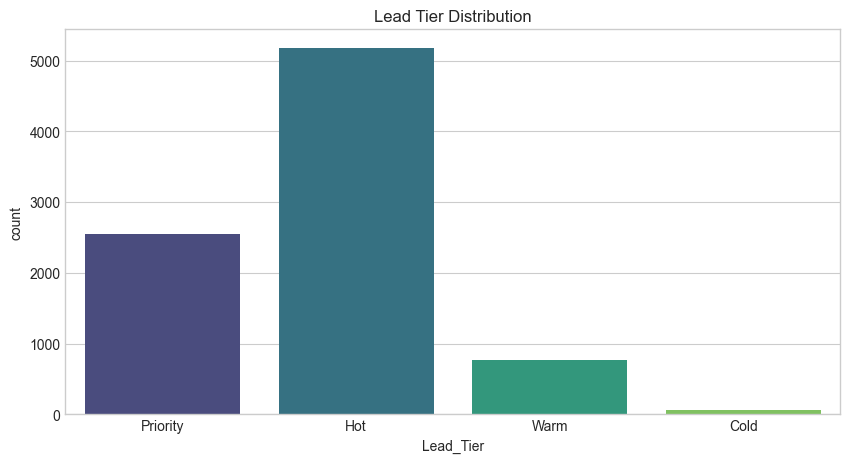

In [140]:
# 1. Cluster Visualization
fig = px.scatter(
    df, x='Log_Revenue', y='Log_Employees', 
    color='Cluster_Name', hover_data=['Revenue (USD)', 'Employees Total'],
    title='Company Clusters: Revenue vs Employees'
)
fig.show()

# 2. Lead Tier Distribution
plt.figure(figsize=(10, 5))
sns.countplot(df, x='Lead_Tier', palette='viridis', order=['Priority', 'Hot', 'Warm', 'Cold'])
plt.title('Lead Tier Distribution')
plt.show()

## 11. Export Results

In [141]:
output_cols = [
    'DUNS Number ', 'Company Sites', 'Country', 'Region', 'Entity Type',
    'SIC Code', 'SIC Description', 'Employees_Total_Clean', 'Revenue_USD_Clean',
    'Is_Revenue_Missing', 'Is_Employees_Missing',
    'Entity_Score', 'Has_Parent', 'Revenue_Per_Employee', 'Data_Completeness',
    'Revenue_vs_Industry', 'Employees_vs_Industry',
    'Cluster', 'Cluster_Name',
    'Lead_Score', 'Lead_Tier',
    'Anomaly_Label', 'Risk_Shell', 'Risk_DataQuality', 'Risk_OrphanSub', 'Risk_Flags'
]

# Save only existing columns
valid_cols = [c for c in output_cols if c in df.columns]
df[valid_cols].to_csv('company_segmentation_results.csv', index=False)
print("💾 Results saved to 'company_segmentation_results.csv'")

💾 Results saved to 'company_segmentation_results.csv'


## 12. AI-Powered Insights (Optional)

In [142]:
try:
    from llm_insights import CompanyInsightGenerator
    llm = CompanyInsightGenerator()
    print("🤖 AI Module Loaded. You can now use `llm.generate_cluster_insight(cluster_id, profile)`")
except ImportError:
    print("⚠️ AI module 'llm_insights.py' not found.")

⚠️ Warning: GEMINI_API_KEY not found. Intelligent features will run in mock mode.
To enable: import os; os.environ['GEMINI_API_KEY'] = 'your_key'
🤖 AI Module Loaded. You can now use `llm.generate_cluster_insight(cluster_id, profile)`
